# HW2P2: Face Classification and Verification


This is the second homework in 11785: Introduction to Deep Learning consisting of two parts:
*   Face Recognition: You will be writing your own CNN model to tackle the problem of classification, consisting of 7001 identities.
*   Face Verification: You use the model trained for classification to evaluate the quality of its feature embeddings, by comparing the similarity of known and unknown identities.

For this HW, you only have to write code to implement your model architecture. Everything else has been provided for you, on the pretext that most of your time will be used up in developing the suitable model architecture for achieving satisfactory performance.

Common errors which you may face in this homeworks (because of the size of the model)


*   CUDA Out of Memory (OOM): You can tackle this problem by (1) Reducing the batch size (2) Calling `torch.cuda.empty_cache()` and `gc.collect()` (3) Finally restarting the runtime



# TODOs
As you go, please read the code and keep an eye out for TODOs.

**Structure of this notebook**:

1. **Libraries** - just run it
2. **Kaggle** - copy the code from HW1P2 and add a correct API key
3. **Configs** - specify your configs
4. **Dataset**
  - **Datasets and Dataloaders** - it's already implemented, just specify your preferred augmentations/transformations
  - **EDA and Viz** - just run it to check if your augmentations/transformations worked
5. **Model Architecture** - implement and define your preferred model architecture
6. **Loss, Optimizer, and Scheduler** - define your loss, optimizer, and a scheduler
7. **Training and Validation Functions** - includes functions for both classification and verification tasks
  - **Classification Task** - just run it
  - **Verification Task** - just run it
8. **Wandb** - add a correct API key
9. **Experiments** - make changes if needed; it will show you train/val/test accuracy for both classification and verification. **Important**: make sure you save your best model checkpoints because models in this HW take a long time to get trained
10. **Testing and Kaggle Submission** - just run it
11. **Model Finetuning** - this part might help you get a higher score on the verification part
  - **Model Implementations (CenterLoss, ArcFace, or SphereFace)** - please refer to the additional notebook and just copy the model from there
  - **Model Definition (finetuning)** - you may reuse the code from the main part
  - **Loss, Optimizer, and Scheduler Definition (finetuning)** - you may reuse the code from the main part
  - **Training Function (finetuning)** - you may reuse the code from the main part
  - **Wandb (finetuning)** - you may reuse the code from the main part
  - **Experiments (finetuning)** - you may reuse the code from the main part

Good luck!

# Libraries

In [1]:
!nvidia-smi # Run this to see what GPU you have

Sun Mar 10 01:17:01 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    31W /  70W |      2MiB / 15360MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#NOTE: RESTART THE RUN TIME AFTER RUNNING THE THE CELL BELOW

In [6]:
# Install the necessary packages. Very important: Please restart your session in Colab/Local Machine
# You can restart your session in colab by going to Runtime and then clicking restart session
!pip install wandb --quiet
!pip install torch==1.13.1 torchvision==0.15 torchaudio==0.12.1

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-1.13.1-cp37-cp37m-manylinux1_x86_64.whl.metadata (24 kB)
ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.11.0
ERROR: Could not find a version that satisfies the requirement torchvision==0.15 (from versions: 0.3.0, 0.4.0, 0.4.1, 0.4.2, 0.5.0, 0.6.0, 0.6.1, 0.7.0, 0.8.0, 0.8.1, 0.8.2, 0.9.0, 0.9.1, 0.10.0, 0.10.1, 0.11.1, 0.11.2, 0.11.3, 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1)
ERROR: No matching distribution found for torchvision==0.15


In [ ]:
# pip install -U git+https://github.com/ankandrew/online-label-smoothing-pt.git

In [4]:
# Import the important packages for this Homework. Feel free to add anything here you need.
import torch
from torchsummary import summary
import torchvision # This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
import torch.nn as nn
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

/home/22941/.local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Device:  cuda


In [ ]:
from google.colab import drive # Link to your drive if you are not using Colab with GCP
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it here

# Kaggle

In [ ]:
# TODO: Use the same Kaggle code from HW1P2
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
# !mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"jianches","key":"c1bda8e22ca7a63a4fe3cd4bc80e5823"}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

In [11]:
# Reminder: Make sure you have connected your kaggle API before running this block
# !mkdir -p'/content/data'

!kaggle competitions download -c 11785-hw2p2-face-recognition
!unzip -qo '11785-hw2p2-face-recognition.zip' -d '\content\data'

!kaggle competitions download -c 11785-hw2p2-face-verification
!unzip -qo '11785-hw2p2-face-verification.zip' -d '\content\data'

/usr/lib/python3/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
11785-hw2p2-face-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)
/usr/lib/python3/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
11785-hw2p2-face-verification.zip: Skipping, found more recently modified local copy (use --force to force download)


# Configs

In [5]:
config = {
    'batch_size': 192, # Increase this if your GPU can handle it
    'lr': 0.1,
    'epochs': 100, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    # Include other parameters as needed.
}

In [6]:
def calculate_mean_std(directory):

    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    dataset = torchvision.datasets.ImageFolder(directory, transform=transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)


    # placeholders
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    # loop through images
    for inputs,_ in tqdm(loader):
      psum    += inputs.sum(axis = [0, 2, 3])
      psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

    ####### FINAL CALCULATIONS

    # pixel count
    count = len(dataset) * 224 * 224

    # mean and std
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    # output
    # print('mean: '  + str(total_mean))
    # print('std:  '  + str(total_std))

    return total_mean, total_std

# Dataset

## Datasets and Dataloaders

In [25]:

# --------------------------------------------------- #

# Data paths

DATA_DIR    =  "\content\data/11-785-s24-hw2p2-classification" # TODO: Path where you have downloaded the classificaation data
TRAIN_DIR   = os.path.join(DATA_DIR, "train")
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

# --------------------------------------------------- #
# find the mean and std
mean, std = calculate_mean_std(TRAIN_DIR)
# Transformations/augmentations of the Train dataset

"""
Refer https://pytorch.org/vision/stable/transforms.html
Implementing the right train transforms/augmentation methods is key to improving performance.
Most torchvision transforms are done on PIL images. So you convert it into a tensor at the end with ToTensor()
But there are some transforms which are performed after ToTensor() : e.g - Normalization
#Normalization Tip - Do not blindly use normalization that is not suitable for this dataset
"""

train_transforms = torchvision.transforms.Compose([torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), torchvision.transforms.RandomHorizontalFlip(p=0.5), torchvision.transforms.RandomRotation(20), 
                                                   torchvision.transforms.RandomPerspective(distortion_scale=0.3), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(mean=mean, std=std)]) # TODO: Specify transformations/augmentations performed on the train dataset

# --------------------------------------------------- #

# Transformations/augmentations of the Val dataset

"""
You should NOT have data augmentation on the validation set. Why?
"""

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(mean=mean, std=std)
    ]) # TODO: Specify transformations performed on the val dataset

# --------------------------------------------------- #

# Initializing the train and val datasets

train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform = valid_transforms)

# --------------------------------------------------- #

# Initializing the train and val dataloaders

train_loader = torch.utils.data.DataLoader(dataset       = train_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = True,
                                           # num_workers = 4, # Uncomment this line if you want to increase your num workers
                                           pin_memory    = True)

valid_loader = torch.utils.data.DataLoader(dataset       = valid_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = False,
                                           # num_workers = 2 # Uncomment this line if you want to increase your num workers
                                           )



100%|██████████| 730/730 [02:03<00:00,  5.89it/s]


In [26]:
# cutmix = torchvision.transforms.v2.CutMix(num_classes=7001)
# mixup = torchvision.transforms.v2.MixUp(num_classes=7001)
# cutmix_or_mixup = torchvision.transforms.v2.RandomChoice([cutmix, mixup])

# for images, labels in train_loader:
#     print(f"Before CutMix/MixUp: {images.shape}, {labels.shape}")
#     images, labels = cutmix_or_mixup(images, labels)
#     print(f"After CutMix/MixUp: {images.shape}, {labels.shape}")

#     # <rest of the training loop here>
#     break

In [27]:
# --------------------------------------------------- #

# Test dataset class

"""
You can do this with ImageFolder as well, but it requires some tweaking
"""

class TestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

# --------------------------------------------------- #

# Initializing the test dataset

"""
Why are we using val_transforms for Test Data?
"""

test_dataset = TestDataset(TEST_DIR, transforms = valid_transforms)

# --------------------------------------------------- #

# Initializing the test dataloader

test_loader = torch.utils.data.DataLoader(dataset    = test_dataset,
                                          batch_size = config['batch_size'],
                                          shuffle     = False,
                                          drop_last  = False,
                                          # num_workers = 2 # Uncomment this line if you want to increase your num workers
                                          )

## EDA and Viz

In [28]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())
print(train_loader)
# Feel free to print more things if needed

Number of classes    :  7001
No. of train images  :  140020
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  192
Train batches        :  730
Val batches          :  183


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

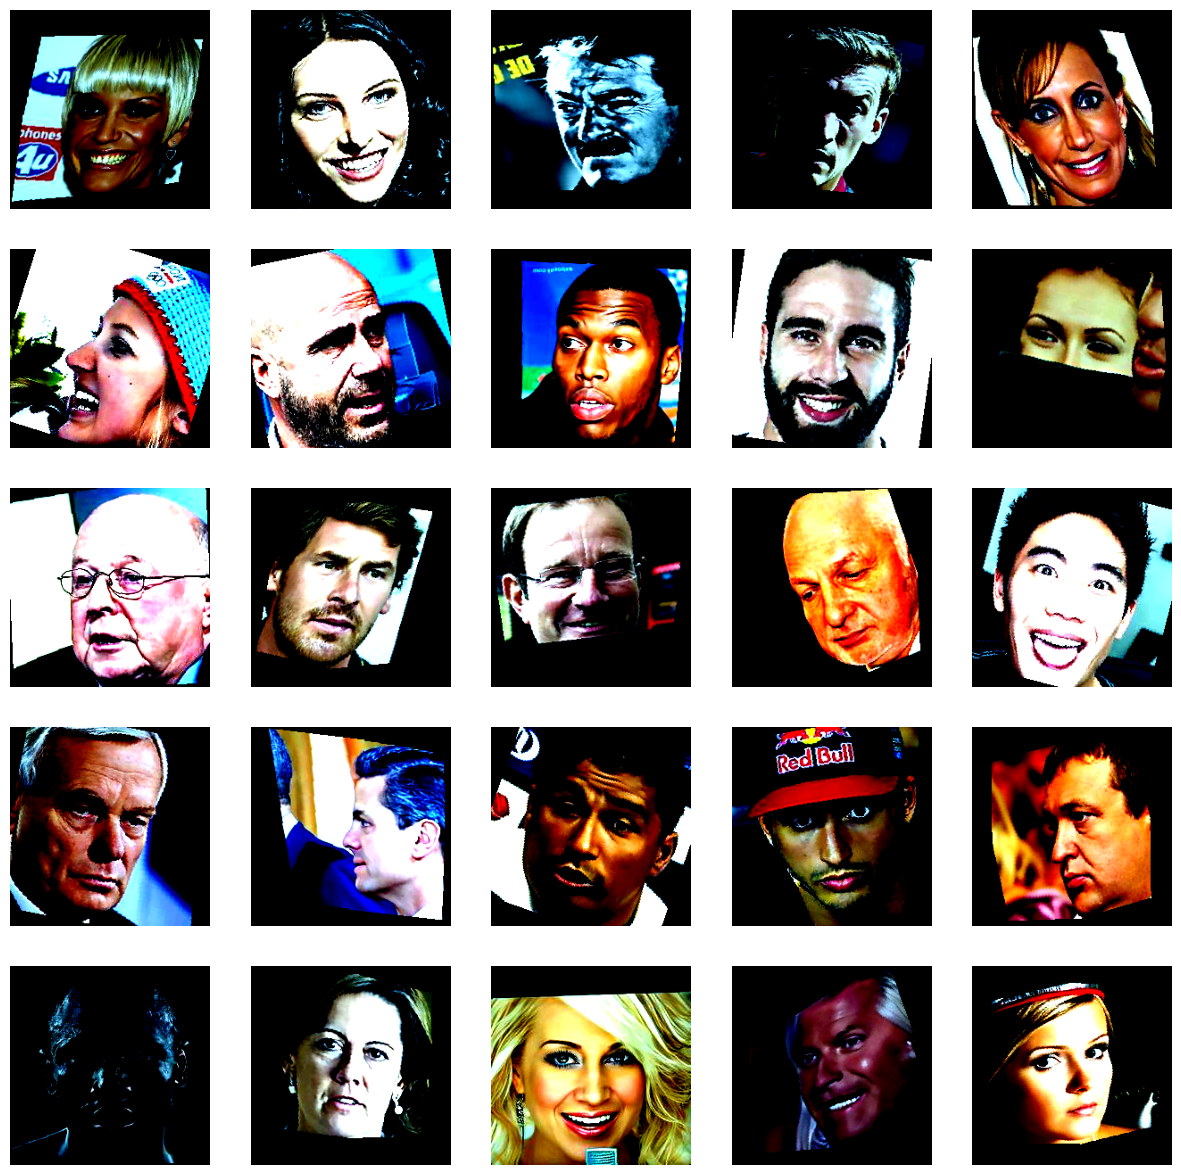

In [29]:
# Visualize a few images in the dataset

"""
You can write your own code, and you don't need to understand the code
It is highly recommended that you visualize your data augmentation as sanity check
"""

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

In [30]:
for i, (images, labels) in enumerate(train_loader):
  print(labels)
  if i == 2:
    break

tensor([1353, 5977, 1327, 2121, 6637, 5160, 1433, 6735, 3927, 6672,  833, 1053,
        5098, 3013, 5098, 4121,  749,  555, 6067, 5661, 4480, 2308, 5019,  131,
        4649, 4074,  944, 1660, 1066, 6254, 3763,  760, 1617, 5566, 5640, 5803,
        1156, 6079,  592, 1238, 3759, 6903, 5233, 4415, 6431, 3267, 3758, 1796,
        1142, 4646, 3310, 3313,  712, 2094, 3636, 1399, 2780, 4543, 3919, 1104,
        2882, 6209, 3734, 6739, 5501, 2565, 2210, 3539, 5170, 5651, 6443, 4567,
        3331,  306, 1137, 6038, 5200, 1983, 5517, 4678, 2442, 3095, 1717, 6263,
        2462, 1229, 4696, 4391, 1119,  191, 3085,  999, 2277, 4603,  907, 1516,
        1232, 3425, 5681, 2814, 6264, 5027, 5064, 2376, 3139,  928, 3862, 3539,
        4728, 1740, 3797, 5587, 2489, 1083, 1187, 3470, 2950, 5136, 1657, 1390,
        2819, 4128, 5571, 6189, 5750, 1718, 6663,  855,  781,  758, 6208, 5493,
        6298, 5736, 4696, 2403, 1574, 2557,  625, 3645,  495, 1787,  145, 3338,
        3624, 5621, 3067, 4476, 6951,  4

# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit is 18M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next four have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 224x224. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [31]:
# This is the architecture for Bottleneck
class Bottleneck(nn.Module):

    def __init__(self, in_channels, mid_channels, expansion=4, stride=1, downsample=None):
        super().__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.conv3 = nn.Conv2d(mid_channels, mid_channels * self.expansion, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(mid_channels * self.expansion)
        self.relu = nn.GELU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != mid_channels * self.expansion:
            self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, mid_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(mid_channels * self.expansion)
            )

    def forward(self, x):
        residual = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


In [32]:
# This is the arch for basic block
class BasicBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels=64, stride=1):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(in_channels, 64, kernel_size=3, padding = 3//2, stride=stride)
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=3, padding = 3//2, stride=stride)
        self.bn = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU()
        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn(out)

        out += identity
        out = self.relu(out)

        return out



In [33]:
# This is the arch for Convnext
class ConvNext_Block(nn.Module):
    r""" ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch
    
    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.2
    """
    def __init__(self, dim, drop_path_value=0.2):
        super().__init__()
        self.drop_path_value = drop_path_value
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.dropout = nn.Dropout2d(p=0.2)
        self.drop_path = torchvision.ops.stochastic_depth

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = self.dropout(x)
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(input=x,p=self.drop_path_value,mode='batch')
        return x

In [ ]:
# This is Convnext network arch the highest submission is not this arch
class ConvNext_Network(torch.nn.Module):

    def __init__(self, num_classes=7001, out_channels_feat = 1024):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(3, 96, kernel_size=4, stride=4)
        self.norm1 = nn.LayerNorm([96,56,56])
        self.block1 = nn.Sequential(ConvNext_Block(dim=96,drop_path_value=0.2), ConvNext_Block(dim=96,drop_path_value=0.2), ConvNext_Block(dim=96,drop_path_value=0.2))
        
        self.norm2 = nn.LayerNorm([96,56,56])
        self.conv2 = torch.nn.Conv2d(96, 192, kernel_size=2, stride=2)
        self.block2 = nn.Sequential(ConvNext_Block(dim=192,drop_path_value=0.2), ConvNext_Block(dim=192,drop_path_value=0.2))
        
        self.norm3 = nn.LayerNorm([192,28,28])
        self.conv3 = torch.nn.Conv2d(192, 384, kernel_size=2, stride=2)
        self.block3 = nn.Sequential(ConvNext_Block(dim=384,drop_path_value=0.2), ConvNext_Block(dim=384,drop_path_value=0.2), ConvNext_Block(dim=384,drop_path_value=0.2))
        
        self.norm4 = nn.LayerNorm([384,14,14])
        self.conv4 = torch.nn.Conv2d(384, 768, kernel_size=2, stride=2)
        self.block4 = nn.Sequential(ConvNext_Block(dim=768,drop_path_value=0.2))
        
        self.pooling = torch.nn.AdaptiveAvgPool2d((1,1))
        self.flatten = torch.nn.Flatten()
        self.norm5 = nn.LayerNorm(normalized_shape=768)
        self.cls_layer = torch.nn.Linear(in_features=768, out_features=num_classes)

    def forward(self, x, return_feats=False):

        feats = self.block1(self.norm1(self.conv1(x)))
        feats = self.block2(self.conv2(self.norm2(feats)))
        feats = self.block3(self.conv3(self.norm3(feats)))
        feats = self.block4(self.conv4(self.norm4(feats)))
        feats = self.pooling(feats)
        feats = self.flatten(feats)
        feats = self.norm5(feats)
        out = self.cls_layer(feats)
        if return_feats:
            return feats
        else:
            return out

# Initialize your model
model = ConvNext_Network().to(DEVICE)
summary(model, (3, 224, 224))

In [15]:
# This is the bottleneck block submission, this is the highest submission

class Network(torch.nn.Module):

    def __init__(self, num_classes=7001, out_channels_feat = 1024):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.pooling1 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.block = torch.nn.Sequential(Bottleneck(in_channels=64, mid_channels=64, stride=1), Bottleneck(in_channels=256, mid_channels=64, stride=1), Bottleneck(in_channels=256, mid_channels=64, stride=1),
                          Bottleneck(in_channels=256, mid_channels=128, stride=2), Bottleneck(in_channels=512, mid_channels=128, stride=1), Bottleneck(in_channels=512, mid_channels=128, stride=1), Bottleneck(in_channels=512, mid_channels=128, stride=1),
                          Bottleneck(in_channels=512, mid_channels=256, stride=2), Bottleneck(in_channels=1024, mid_channels=256, stride=1), Bottleneck(in_channels=1024, mid_channels=256, stride=1), Bottleneck(in_channels=1024, mid_channels=256, stride=1),
                          Bottleneck(in_channels=1024, mid_channels=512, stride=2, expansion=2))
        self.pooling2 = torch.nn.AdaptiveAvgPool2d((1,1))
        self.flatten = torch.nn.Flatten()
        self.cls_layer = torch.nn.Linear(in_features=out_channels_feat, out_features=num_classes)

    def forward(self, x, return_feats=False):

        feats = self.flatten(self.pooling2(self.block(self.pooling1(self.conv1(x)))))
        out = self.cls_layer(feats)
        if return_feats:
            return feats
        else:
            return out

# Initialize your model
model = Network().to(DEVICE)
summary(model, (3, 224, 224))

# Loss, Optimizer, and Scheduler Definition

In [36]:

# --------------------------------------------------- #
#label smoothing
# Defining Loss function
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # TODO: What loss do you need for a multi class classification problem and would label smoothing be beneficial here?


# --------------------------------------------------- #

# Defining Optimizer
optimizer = torch.optim.SGD(model.parameters(),
                            lr=config['lr'],
                            momentum=0.9,
                            weight_decay=1e-4) # TODO: Feel free to pick a different optimizer

# --------------------------------------------------- #

# Defining Scheduler
# TODO: Use a good scheduler such as ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, threshold=1e-2, threshold_mode = 'rel', factor=0.5)
# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

# Training and Validation Functions

## Classification Task

In [37]:
def train(model, dataloader, optimizer, criterion):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(images)
            # print('unsmoothed_labels', outputs.shape)
            # outputs = label_smoothing(outputs, smoothing, classes=7001)
            # print('smoothed_labels', outputs.shape)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?

        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [38]:
def validate(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [39]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

## Verification Task

The verification task consists of the following generalized scenario:
- You are given X unknown identitites
- You are given Y known identitites
- Your goal is to match X unknown identities to Y known identities.

We have given you a verification dataset, that consists of 960 known identities, and 1080 unknown identities. The 1080 unknown identities are split into dev (360) and test (720). Your goal is to compare the unknown identities to the 960 known identities and assign an identity to each image from the set of unknown identities. Some unknown identities do not have correspondence in known identities, you also need to identify these and label them with a special label n000000.

Your will use/finetune your model trained for classification to compare images between known and unknown identities using a similarity metric and assign labels to the unknown identities.

This will judge your model's performance in terms of the quality of embeddings/features it generates on images/faces it has never seen during training for classification.

In [40]:
# This obtains the list of known identities from the known folder
known_regex = "\content\data/11-785-s24-hw2p2-verification/known/*/*"
known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
unknown_dev_regex = "\content\data/11-785-s24-hw2p2-verification/unknown_dev/*"
unknown_test_regex = "\content\data/11-785-s24-hw2p2-verification/unknown_test/*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

# Why do you need only ToTensor() here?
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6)

  0%|          | 0/720 [00:00<?, ?it/s]

100%|██████████| 960/960 [00:00<00:00, 16086.24it/s]


In [41]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'):

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size

        with torch.no_grad():
            unknown_feat = model(unknown_batch.float().to(DEVICE), return_feats=True) #Get features from model
        unknown_feats.append(unknown_feat)
        batch_bar.update()

    batch_bar.close()

    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)

    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size]
        with torch.no_grad():
              known_feat = model(known_batch.float().to(DEVICE), return_feats=True)

        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats])
    # Print the inner list comprehension in a separate cell - what is really happening?

    max_similarity_values, predictions = similarity_values.max(0) #Why are we doing an max here, where are the return values?
    max_similarity_values, predictions = max_similarity_values.cpu().numpy(), predictions.cpu().numpy()


    # Note that in unknown identities, there are identities without correspondence in known identities.
    # Therefore, these identities should be not similar to all the known identities, i.e. max similarity will be below a certain
    # threshold compared with those identities with correspondence.

    # In early submission, you can ignore identities without correspondence, simply taking identity with max similarity value
    # pred_id_strings = [known_paths[i] for i in predictions] # Map argmax indices to identity strings

    # After early submission, remove the previous line and uncomment the following code

    threshold = 0.7 # Choose a proper threshold
    NO_CORRESPONDENCE_LABEL = 'n000000'
    pred_id_strings = []
    for idx, prediction in enumerate(predictions):
        if max_similarity_values[idx] < threshold: # why < ? Thank about what is your similarity metric
            pred_id_strings.append(NO_CORRESPONDENCE_LABEL)
        else:
            pred_id_strings.append(known_paths[prediction])

    if mode == 'val':
      true_ids = pd.read_csv('\content\data/11-785-s24-hw2p2-verification/verification_dev.csv')['label'].tolist()
      accuracy = 100 * accuracy_score(pred_id_strings, true_ids)
      #print("Verification Accuracy = {}".format(accuracy))
      return accuracy, pred_id_strings

    elif mode == 'test':
      return pred_id_strings


In [42]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Wandb

In [ ]:
wandb.login(key="efb5ba10afc754fad55f8408759058272e35301f") # API Key is in your wandb account, under settings (wandb.ai/settings)

In [ ]:
# Create your wandb run
run = wandb.init(
    name = "5-resnet", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

# Experiments

In [ ]:
best_class_acc      = 0.0
best_ver_acc        = 0.0

for epoch in range(config['epochs']):

    # print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model=model, dataloader=train_loader, optimizer=optimizer, criterion=criterion) # TODO: What function would you want implement here

    print("\nEpoch {}/{}: \nTrain Acc (Classification) {:.04f}%\t Train Loss (Classification) {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config['epochs'], train_acc, train_loss, curr_lr))

    val_acc, val_loss = validate(model=model, dataloader=valid_loader, criterion=criterion) # TODO: What function would you want implement here
    print("Val Acc (Classification) {:.04f}%\t Val Loss (Classification) {:.04f}".format(val_acc, val_loss))

    ver_acc, pred_id_strings = eval_verification(unknown_dev_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='val')

    print("Val Acc (Verification) {:.04f}%\t ".format(ver_acc))

    wandb.log({"train_classification_acc": train_acc,
               "train_classification_loss":train_loss,
               "val_classification_acc": val_acc,
               "val_classification_loss": val_loss,
               "val_verification_acc": ver_acc,
               "learning_rate": curr_lr})

    # If you are using a scheduler in your train function within your iteration loop,
    # How will you step your scheduler ?
    scheduler.step(val_acc)
    if val_acc >= best_class_acc:
        best_valid_acc = val_acc
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'scheduler_state_dict':scheduler.state_dict(),
                    'val_acc': val_acc,
                    'epoch': epoch}, './checkpoint_classification_Convnext.pth')
        wandb.save('checkpoint_classification_Convnext.pth')
        print("Saved best classification model")

    if ver_acc >= best_ver_acc:
      best_ver_acc = ver_acc
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': ver_acc,
                  'epoch': epoch}, './checkpoint_verification_Convnext.pth')
      wandb.save('checkpoint_verification_Convnext.pth')
      print("Saved verification model")

### Finish your wandb run
run.finish()

# Retrieve the previous and continue training

In [ ]:
# Create your wandb run
run = wandb.init(
    name    = "5-resnet", ### Wandb creates random run names if you skip this field, we recommend you give useful names
    #reinit  = True, ### Allows reinitalizing runs when you re-run this cell
    id     = "s6v5f39l", ### Insert specific run id here if you want to resume a previous run
    resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config  = config ### Wandb Config for your run
)

## Retreiving the model
model_weights = torch.load('./checkpoint_classification_Convnext.pth')

#
model.load_state_dict(model_weights['model_state_dict'])

# # Loading weights
# model.load_state_dict(model_dict['model_state_dict'])
# Loading optimizer state
# optimizer.load_state_dict(model_dict['optimizer_state_dict'])
# change the learning rate
# optimizer.load_state_dict(model_weights['optimizer_state_dict'])
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01,
                            momentum=0.9,
                            weight_decay=1e-4) # Manually set the learning rate for new optimizer


In [ ]:
best_class_acc      = 0.0
best_ver_acc        = 0.0

for epoch in range(config['epochs']):

    # print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model=model, dataloader=train_loader, optimizer=optimizer, criterion=criterion) # TODO: What function would you want implement here

    print("\nEpoch {}/{}: \nTrain Acc (Classification) {:.04f}%\t Train Loss (Classification) {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config['epochs'], train_acc, train_loss, curr_lr))

    val_acc, val_loss = validate(model=model, dataloader=valid_loader, criterion=criterion) # TODO: What function would you want implement here
    print("Val Acc (Classification) {:.04f}%\t Val Loss (Classification) {:.04f}".format(val_acc, val_loss))

    ver_acc, pred_id_strings = eval_verification(unknown_dev_images, known_images, model, similarity_metric, config['batch_size'], mode='val')

    print("Val Acc (Verification) {:.04f}%\t ".format(ver_acc))

    wandb.log({"train_classification_acc": train_acc,
               "train_classification_loss":train_loss,
               "val_classification_acc": val_acc,
               "val_classification_loss": val_loss,
               "val_verification_acc": ver_acc,
               "learning_rate": curr_lr})

    # If you are using a scheduler in your train function within your iteration loop,
    # How will you step your scheduler ?
    scheduler.step(val_acc)
    if val_acc >= best_class_acc:
        best_class_acc = val_acc
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'scheduler_state_dict':scheduler.state_dict(),
                    'val_acc': val_acc,
                    'epoch': epoch}, './checkpoint_classification_Convnext.pth')
        wandb.save('checkpoint_classification_Convnext.pth')
        print("Saved best classification model")

    if ver_acc >= best_ver_acc:
      best_ver_acc = ver_acc
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': ver_acc,
                  'epoch': epoch}, './checkpoint_verification_Convnext.pth')
      wandb.save('checkpoint_verification_Convnext.pth')
      print("Saved verification model")

### Finish your wandb run
run.finish()

# Testing and Kaggle Submission (didn't change compared to previous )

In [25]:
def test(model,dataloader): # TODO: Run to finish predicting on the test set.

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []

  for i, (images) in enumerate(dataloader):

      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)

      batch_bar.update()

  batch_bar.close()
  return test_results

In [27]:
test_results = test(model, test_loader)

In [71]:
pred_id_strings = eval_verification(unknown_test_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='test')

In [72]:
# TODO: Run to write the results in the files and submit to Kaggle
# You only have 10 Kaggle submissions per day

with open("classification_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(6) + ".jpg", test_results[i]))

with open("verification_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))

In [ ]:
!kaggle competitions submit -c 11785-hw2p2-face-recognition -f classification_submission.csv -m "Submission"
!kaggle competitions submit -c 11785-hw2p2-face-verification -f verification_submission.csv -m "Submission"

# Finetune your Model 

You can choose any model for finetuning. It is a good practice to try to sweep through all the models to find what is the best finetuning model for you!

## Model Definition (finetuning)

This is the Arcface model

In [ ]:
# add your finetune/retrain code here
class ArcFaceModel(torch.nn.Module):
    '''
    To train in a standard training loop make sure to modify the train function so you pass in the inputs and the labels
    i.e. output = model(images, labels)
    Experiment with different values of margin and scaler
    '''
    def __init__(self, model, margin=0.5, scaler=64, embedding_size=1024, num_classes=7001):
        super(ArcFaceModel, self).__init__()
        self.embedding_size = embedding_size
        self.num_classes = num_classes

        # small number to avoid invalid arcCos values
        self.eps = 1e-7

        # hyperparameters
        self.margin = margin
        self.scaler = scaler

        # load classification model
        self.model = model

        # Initializing the arcface linear layer with the weights of the classifier from the trained CNN
        self.AFL_linear = torch.nn.Linear(embedding_size, num_classes, bias=False) # Why set bias=False? Check out the paper.
        with torch.no_grad():
          self.AFL_linear.weight.copy_(self.model.cls_layer.weight)

        # Initializing utility functions for normalization, arcCos, cos and onehot encoding
        self.normalizer = torch.nn.functional.normalize
        self.arcCos = torch.acos
        self.cos = torch.cos
        self.one_hot = torch.nn.functional.one_hot


    def forward(self, x, labels):
        # Get face embedding. Note that we pass return_feats=True to get the image's features and not the final logits.
        embedding = self.model(x, return_feats=True)

        # TODO: normalize face embedding
        embedding = self.normalizer(embedding)

        # TODO: normalize linear layer weights.
        # NOTE: The normalized weights need to be wrapped in torch.nn.Parameter before assigning to AFL_linear.
        with torch.no_grad():
          self.AFL_linear.weight = torch.nn.Parameter(self.normalizer(self.AFL_linear.weight))

        # TODO: take dot product to get cos theta, remember that Wx = ||W||||x||cos(\theta) and ||W|| = 1, ||x|| = 1
        cosine =  torch.matmul(embedding, self.AFL_linear.weight.T)

        # We clamp the values to be a little higher than -1 and a little lower than one so we don't get nan values when we call arccos
        cosine = torch.clamp(cosine, min=-1.0+self.eps, max=1.0-self.eps)

        # TODO: get theta by performing arccos(cos(theta))
        theta = torch.acos(cosine)

        # TODO: convert labels to one-hot
        # print(f'label before one hot: {labels}, {labels.shape}')
        one_hot_labels = self.one_hot(labels, num_classes = 7001)
        # TODO: create a mask with m at positions with label 1 and 0 at positions with label 0
        
        # print(f'onehot label shape: {one_hot_labels.shape}')
        
        margin_mask = one_hot_labels * self.margin
        # TODO: add margin m to theta
        theta_m = theta + margin_mask

        # calculate the cosine value for theta with margin added and scale with self.scaler
        new_cosine = self.scaler * torch.cos(theta_m)
        logits = new_cosine # this value is then passed to crossEntropyLoss in train loop to calculate arcface loss

        return logits

This is the definition for Center loss

In [ ]:
class CenterLoss(nn.Module):
    """Center Loss
        Center Loss Paper:
        https://ydwen.github.io/papers/WenECCV16.pdf
    Args:
        nn (_type_): _description_
    """
    def __init__(self,
                 num_classes=7001, # TODO: What is the number of classes for our model?
                 feat_dim=1024, # TODO: What is the dimension of your output feature?
                 ) -> None:
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim

        # I have written the initialization of centers for you here
        # Consider why the shape of centers is (num_classes, feat_dim)
        # You may want to adjust here if you want to test the program on cpu
        self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.shape[0]
        # centers = []
        # for i in range(len(labels)):
        #     centers.append(self.centers[labels[i],:])
        # print(len(centers))
        # centers = np.array(centers)
        # print(centers[1].shape)
        # centers = torch.tensor(centers) # TODO: Broadcast your self.centers so that centers[i] will contain the center of true label of x[i]
        centers = self.centers[labels].reshape((batch_size,-1))
        # print(centers.shape) #reduce the extra one dimension on the centers
        x = torch.tensor(x)
        dist = 0.5 * torch.sum(torch.square(centers-x), dim=1)# TODO: Calculate the squared euclidian distances between your inputs and current centers this is the dim(batch size, 1)
        # print(f'dis: {dist.shape}')
        # Each element in dist is actually the Center Loss of each input

        # Here you have to first wrap 'dist' inside torch.clamp() function, because log(0) will cause NaN output.
        # To avoid the 0 in 'dist', we will set the lower bound in 'dist' to a value that is close to 0

        dist = torch.clamp(dist, min=1e-12, max=1e+12)

        loss = torch.mean(dist)# TODO: Calculate the mean loss across the batch.

        return loss
    
# test_loss = CenterLoss(num_classes=7001, feat_dim=1024)
# loss = test_loss.forward(x=np.random.rand(192,1024), labels=np.random.rand(192,1))
# print(loss)

## Loss, Optimizer, and Scheduler Definition (finetuning)

This is for retrieve the trained model

In [ ]:
# add your finetune/retrain code here
## Retreiving the model

# model = Network().to(DEVICE)
# summary(model,(3,224,224))
model_weights = torch.load('./checkpoint_verification.pth')

model.load_state_dict(model_weights['model_state_dict'])

# # Loading weights
# model.load_state_dict(model_dict['model_state_dict'])
# Loading optimizer state
# optimizer.load_state_dict(model_dict['optimizer_state_dict'])
# change the learning rate
# optimizer = torch.optim.SGD(model.parameters(),
#                             lr=config['lr'],
#                             momentum=0.9,
#                             weight_decay=1e-4) # This is the old model optimizer
# optimizer.load_state_dict(model_weights['optimizer_state_dict']) #update the old model optimizer parameter becasue we already trained that, the paremeter will be a different value 

<All keys matched successfully>

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

This is for arcface finetune definition

In [ ]:
# This is for arcface and cosface loss

finetune_model = ArcFaceModel(model,  margin=0.5, scaler=64, embedding_size=1024, num_classes=7001).to(DEVICE)
# Initialize your model
finetune_criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
finetune_epochs = 20
finetune_optimizer = torch.optim.SGD(finetune_model.parameters(), lr=config['lr'], momentum=0.9, weight_decay=1e-4)
finetune_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(finetune_optimizer, 'max', patience=3, threshold=1e-4, threshold_mode = 'rel', factor=0.7)
finetune_scalar = torch.cuda.amp.GradScaler()

In [ ]:
config_finetune = {
    'batch_size': 64, # Increase this if your GPU can handle it
    'lr': 0.01,
    'epochs': 100, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    # Include other parameters as needed.
}

This is for center loss fine tune definition

In [ ]:
# This is for center loss
optimizer = torch.optim.SGD(model.parameters(),
                            lr = config_finetune['lr'],
                            momentum=0.9,
                            weight_decay=1e-4) # This is the old model optimizer
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # this is the original cross entropy loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, threshold=1e-4, threshold_mode = 'rel', factor=0.7) # This is the original loss scheduler
center_loss = CenterLoss(num_classes=7001, feat_dim=1024) # this is the new center loss model to pass into center loss optimizer
optimizer_center_loss = torch.optim.SGD(model.parameters(), lr = 0.5) # This is the center loss optimizer 
center_loss_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, threshold=1e-2, threshold_mode = 'rel', factor=0.5) # this is the center loss scheduler
scalar = torch.cuda.amp.GradScaler()

## Training Function (finetuning)

This is for arcface finetune train

In [ ]:
def finetune_train(model, dataloader, optimizer, criterion, scaler):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # print(labels.shape)
        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(images, labels) #Why are we giving labels as well in here ?
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?
        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

This is for center loss fine tune train

In [ ]:
def train_centerloss(model,#here we use the after training model
          train_loader,#here we use the train loader
          optimizer,#here we use the original optimizer
          optimizer_center_loss,#here we use the center loss optimizer
          criterion: nn.Module,# here we use the original crossentropy loss
          fine_tuning_loss, # here we are using Center Loss as our fine_tuning_loss
          loss_weight,
          scheduler,
          device,
          scaler):

    num_correct = 0.0
    total_loss = 0.0
    model.train()

    # Progress Bar
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        optimizer_center_loss.zero_grad()

        images, labels = images.to(device), labels.to(device)

        with torch.cuda.amp.autocast():
            outputs = model(images, return_feats=False)
            feats = model(images, return_feats=True)
            loss0 = criterion(outputs, labels) # calculate cross entropy loss from outputs and labels
            loss1 = loss_weight * fine_tuning_loss(feats, labels) # calculate weighted fine_tuning_loss (center loss) from feats and labels
            loss = loss0 + loss1

        # Update no. of correct predictions & loss as we iterate
        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct,
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))


        # backward loss0 to calculate gradients for model paramters
        # Hint: You have to pass retain_graph=True here, so that the scaler will remember this backward call
        scaler.scale(loss0).backward(retain_graph=True)

        # backward loss1 to calculate gradients for fine_tuning_loss paramters
        scaler.scale(loss1).backward()

        # update fine tuning loss' parameters
        # the paramerters should be adjusted according to the loss_weight you choose
        for parameter in fine_tuning_loss.parameters():
            parameter.grad.data *= (1.0 / loss_weight)

        scaler.step(optimizer_center_loss)
        scaler.step(optimizer)
        scaler.update()
        batch_bar.update() # Update tqdm bar

        # if you use a scheduler to schedule your learning rate for Center Loss
        # scheduler.step()

        del images, labels, outputs, loss0, loss1
        torch.cuda.empty_cache()

    batch_bar.close() # You need this to close the tqdm bar
    acc = 100 * num_correct / (config['batch_size']* len(train_loader))
    total_loss = float(total_loss / len(train_loader))

    return acc, total_loss

## Wandb (finetuning)

In [ ]:
# os.environ["WANDB_API_KEY"] = "4092212a3c22ddead614f9f9d5aeacd90dfd2773"        ## enter API KEY
wandb.login(key="0bd1e940f8cf3130e2b2ec3795ff17c6ad5cbfec")
# !wandb login --relogin

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/usr/lib/python3/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: Currently logged in as: jianches. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/22941/.netrc


True

In [ ]:
# WANDB_HTTP_TIMEOUT=300
# WANDB_INIT_TIMEOUT =600
# WANDB_DEBUG=True
# add your finetune/retrain code here
# Create your wandb run
# run - wandb.init()
run = wandb.init(
    name    = "finetuning9_relu_resnet", ### Wandb creates random run names if you skip this field, we recommend you give useful names
    reinit  = True, ### Allows reinitalizing runs when you re-run this cell
    # id     = "s6v5f39l", ### Insert specific run id here if you want to resume a previous run
    # resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-finetune", ### Project should be created in your wandb account
    config  = config_finetune ### Wandb Config for your run
)

## Experiments (finetuning)

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

This is for center loss finetune training loop

In [ ]:
# This is for center loss
# add your finetune/retrain code here
best_class_acc      = 0.0
best_ver_acc        = 0.0

for epoch in range(config_finetune['epochs']):

    # print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr = float(optimizer_center_loss.param_groups[0]['lr'])

    train_acc, train_loss = train_centerloss(model=model,train_loader=train_loader,optimizer=optimizer,optimizer_center_loss=optimizer_center_loss,criterion=criterion,fine_tuning_loss=center_loss,
                                             loss_weight=3e-3,scheduler=center_loss_scheduler,device=DEVICE,scaler=torch.cuda.amp.GradScaler())# TODO: What function would you want implement here

    print("\nEpoch {}/{}: \nTrain Acc (Classification) {:.04f}%\t Train Loss (Classification) {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config_finetune['epochs'], train_acc, train_loss, curr_lr))

    val_acc, val_loss = validate(model=model, dataloader=valid_loader, criterion=criterion) # TODO: What function would you want implement here
    print("Val Acc (Classification) {:.04f}%\t Val Loss (Classification) {:.04f}".format(val_acc, val_loss))

    ver_acc, pred_id_strings = eval_verification(unknown_dev_images, known_images, model, similarity_metric, config_finetune['batch_size'], mode='val')

    print("Val Acc (Verification) {:.04f}%\t ".format(ver_acc))

    wandb.log({"train_classification_acc": train_acc,
               "train_classification_loss":train_loss,
               "val_classification_acc": val_acc,
               "val_classification_loss": val_loss,
               "val_verification_acc": ver_acc,
               "learning_rate": curr_lr})

    # If you are using a scheduler in your train function within your iteration loop,
    # How will you step your scheduler ?
    scheduler.step(val_acc)
    center_loss_scheduler.step(ver_acc)
    if val_acc >= best_class_acc:
        best_class_acc = val_acc
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'scheduler_state_dict':scheduler.state_dict(),
                    'val_acc': val_acc,
                    'epoch': epoch}, './checkpoint_classification_finetune.pth')
        wandb.save('checkpoint_classification_finetune.pth')
        print("Saved best classification_finetune model")

    if ver_acc >= best_ver_acc:
      best_ver_acc = ver_acc
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': ver_acc,
                  'epoch': epoch}, './checkpoint_verification_finetune.pth')
      wandb.save('checkpoint_verification_finetune.pth')
      print("Saved verification_finetune model")

### Finish your wandb run
run.finish()

This is for arcface loss finetune training loop

In [ ]:

# add your finetune/retrain code here
best_class_acc      = 0.0
best_ver_acc        = 0.0

for epoch in range(config['epochs']):

    # print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr = float(finetune_optimizer.param_groups[0]['lr'])

    train_acc, train_loss = finetune_train(model=finetune_model, dataloader=train_loader, optimizer=finetune_optimizer, criterion=finetune_criterion, scaler=finetune_scalar) # TODO: What function would you want implement here

    print("\nEpoch {}/{}: \nTrain Acc (Classification) {:.04f}%\t Train Loss (Classification) {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config['epochs'], train_acc, train_loss, curr_lr))

    val_acc, val_loss = validate(model=model, dataloader=valid_loader, criterion=finetune_criterion) # TODO: What function would you want implement here
    print("Val Acc (Classification) {:.04f}%\t Val Loss (Classification) {:.04f}".format(val_acc, val_loss))

    ver_acc, pred_id_strings = eval_verification(unknown_dev_images, known_images, model, similarity_metric, config['batch_size'], mode='val')

    print("Val Acc (Verification) {:.04f}%\t ".format(ver_acc))

    wandb.log({"train_classification_acc": train_acc,
               "train_classification_loss":train_loss,
               "val_classification_acc": val_acc,
               "val_classification_loss": val_loss,
               "val_verification_acc": ver_acc,
               "learning_rate": curr_lr})

    # If you are using a scheduler in your train function within your iteration loop,
    # How will you step your scheduler ?
    scheduler.step(val_acc)
    if val_acc >= best_class_acc:
        best_valid_acc = val_acc
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'scheduler_state_dict':scheduler.state_dict(),
                    'val_acc': val_acc,
                    'epoch': epoch}, './checkpoint_classification_finetune.pth')
        wandb.save('checkpoint_classification_finetune.pth')
        print("Saved best classification_finetune model")

    if ver_acc >= best_ver_acc:
      best_ver_acc = ver_acc
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': ver_acc,
                  'epoch': epoch}, './checkpoint_verification_finetune.pth')
      wandb.save('checkpoint_verification_finetune.pth')
      print("Saved verification_finetune model")

### Finish your wandb run
run.finish()